# Custom Modeling Workflow

This notebook demonstrates a flexible approach to power system modeling using individual PowNet classes directly, rather than relying solely on the `Simulator` class shown in the "Quick start" example. This custom workflow offers greater control and mirrors the underlying process used by the `Simulator` class itself.

In this example, we simulate the day-ahead unit commitment and economic dispatch (UC-ED) over a 24-hour horizon for three consecutive days. The power system model, named "solar_ess", includes one thermal unit and one integrated solar photovoltaic (PV) and battery energy storage system (BESS) unit, connected across two substations. The system configuration is illustrated below.

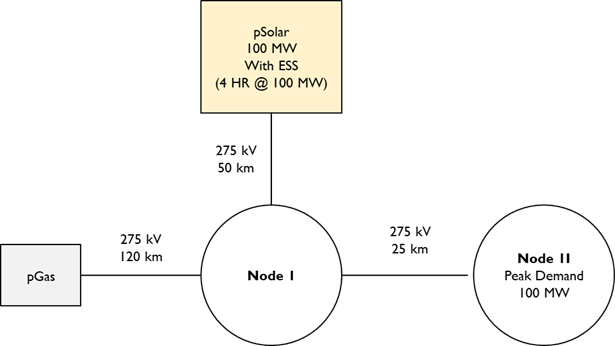

In [1]:
import os
from IPython.display import Image, display
from pownet.folder_utils import get_pownet_dir

project_root = get_pownet_dir()
image_path = os.path.join(project_root, "images", "solar_ess.png")
display(Image(filename=image_path))

## Setup: Input/Output Folders and Simulation Parameters

First, we specify the directory containing the input data for the power system model using `input_folder`. If simulation results need to be saved, we also define the `output_folder`. 

Next, we set key simulation parameters:

* `model_name`: The identifier for the power system case ("solar_ess")
* `model_year`: The year for which the simulation data belongs
* `sim_horizon`: The duration of each individual optimization run, typically representing the day-ahead market horizon (24 hours)
* `steps_to_run`: The total number of sequential simulation runs to execute (running the 24-hour simulation 3 times for 3 consecutive days)
* `solver`: The mathematical optimization solver

In [2]:
import os
from datetime import datetime

from pownet.core import (
    DataProcessor,       # For processing raw input data
    SystemInput,         # For loading and validating model inputs
    ModelBuilder,        # For constructing the optimization model
    SystemRecord,        # For storing simulation results
    OutputProcessor,     # For post-processing results
    Visualizer,          # For plotting results
)
# Import utility for creating initial conditions
from pownet.data_utils import create_init_condition


# Define input and output directories relative to the project root.
# Note: Adjust these paths if you installed PowNet via pip and your data is elsewhere.
input_folder = os.path.join(project_root, "model_library")
output_folder = os.path.join(project_root, "outputs")

# Define the specific model name and year
model_name = "solar_ess"
model_year = 2016

# Simulation parameters
sim_horizon = 24  # Simulation horizon in hours
steps_to_run = 3  # Number of simulation days (3 * 24 hours = 72 hours total)
solver = "gurobi"  # Specify the optimization solver ('gurobi' or 'highs')

## Data Preprocessing

PowNet requires certain preprocessed data files in addition to user-provided inputs. The `DataProcessor` class automatically generates these necessary files if they don't exist. These files, prefixed with `pownet_`, contain information like derated capacities (for transmission lines, thermal units, storage units) and basic cycles in the network. They are saved within the model's input folder.

If the underlying system parameters (capacities, network topology) remain unchanged, these `pownet_` files only need to be generated once. This improves computational efficiency, especially during sensitivity analyses or when exploring uncertainties like renewable energy variability, as preprocessing is skipped on subsequent runs.

In [3]:
data_processor = DataProcessor(
    input_folder=input_folder, model_name=model_name, year=2016, frequency=50
)
data_processor.execute_data_pipeline()

## Loading System Inputs

The `SystemInput` class is responsible for reading all the model input CSV files (both user-provided and auto-generated) and performing data validation checks to ensure correct formatting and consistency.

This class also takes penalty factors as arguments. The power balance at each node is formulated as an equality constraint. Therefore, to handle potential infeasibilities or economic decisions, penalty variables are included:

* `load_shortfall_penalty_factor`: The cost ($/MWh) incurred for failing to meet the electrical demand (load) at a node. This represents the value of lost load.
* `load_curtail_penalty_factor`: The cost ($/MWh) associated with *oversupplying* energy at a node (i.e., generation exceeding load and losses where the excess cannot be stored or transmitted). *(Note: The naming might be slightly confusing; this penalty applies to energy exceedance, not load curtailment in the typical sense. This may be revised in future PowNet versions).*
* `spin_shortfall_penalty_factor`: The cost ($/MWh) for failing to meet the spinning reserve requirement.

In [4]:
# Initialize SystemInput with paths, model details, simulation horizon, and penalty factors
inputs = SystemInput(
    input_folder=input_folder,
    model_name=model_name,
    year=model_year,
    sim_horizon=sim_horizon,
    spin_reserve_factor=0.15, # Spinning reserve requirement as a fraction of load at each hour
    load_shortfall_penalty_factor=1000, # Penalty for unmet demand ($/MWh)
    load_curtail_penalty_factor=10, # Penalty for energy surplus ($/MWh)
    spin_shortfall_penalty_factor=1000, # Penalty for unmet spinning reserve ($/MWh)
)
# Load and validate the input data from CSV files
inputs.load_and_check_data()




PowNet Input Data Summary:
        Timestamp                 = 20250428_1941
        Model name                = solar_ess
        Year                      = 2016
        ---- System characteristics ----
        No. of nodes              = 4
        No. of edges              = 3
        No. of thermal units      = 1
        No. of demand nodes       = 1
        Peak demand               = 100 MW

        ---- Renewable capacities ----
        Hydropower units          = 0
        Daily hydropower units    = 0
        Solar units               = 1
        Wind units                = 0
        Import units              = 0

        ---- Energy storage ----
        No. of hydropower with ESS = 0
        No. of daily hydropower with ESS = 0
        No. of Solar with ESS     = 1
        No. of Wind with ESS      = 0
        No. of Thermal units with ESS = 0
        No. of Grid ESS           = 0

        ---- Modeling parameters ----
        Simulation horizon        = 24 hours
        N

## Initial Conditions

For the very first simulation step (day 1, hour 0), we need to define the initial state of components that have time-coupling constraints, such as thermal units (on/off status, time since last status change) and energy storage (state of charge).

The `create_init_condition` utility function generates a dictionary representing a "cold start" state: thermal units are initially offline, and storage units are empty. Users can also manually create this dictionary, ensuring it follows the required format, to specify different starting conditions.

In [5]:
init_conditions = create_init_condition(inputs.thermal_units, inputs.storage_units)
print(init_conditions)

{'initial_p': {'pGas': 0}, 'initial_u': {'pGas': 0}, 'initial_v': {'pGas': 0}, 'initial_w': {'pGas': 0}, 'initial_min_on': {'pGas': 0}, 'initial_min_off': {'pGas': 0}, 'initial_charge_state': {'solar_ess': 0}}


## Model Building and Simulation Setup

With the inputs loaded and initial conditions defined, we instantiate the core classes needed for running the simulation loop:

* `ModelBuilder`: Takes the `SystemInput` object and is responsible for constructing the optimization problem (variables, constraints, objective function) for each time step.
* `SystemRecord`: Takes the `SystemInput` object and is used to store the results (variable values, objective value, runtime) from each simulation step.

In [6]:
model_builder = ModelBuilder(inputs)
record = SystemRecord(inputs)

Set parameter Username
Set parameter LicenseID to value 2593676
Academic license - for non-commercial use only - expires 2025-12-01


## Simulation Loop

Now we execute the simulation step-by-step for the defined `steps_to_run`. Inside the loop:
1.  **Build/Update Model**: For the first step (`step_k == 1`), we build the optimization model from scratch using `model_builder.build()`, passing the initial conditions. For subsequent steps, we efficiently update the existing model instance with new time-dependent data (load, renewables) and the initial conditions derived from the previous step's end state, using `model_builder.update()`. This update approach significantly reduces runtime compared to rebuilding the model each time.
2.  **Optimize**: We solve the optimization problem using the selected solver via `power_system_model.optimize()`. Parameters like `mipgap` (optimality tolerance) can be specified. An alternative solving method using a rounding heuristic (`optimize_with_rounding_heuristic()`) is also available.
3.  **Check Feasibility**: It's crucial to verify if the solver found a feasible solution. If not, an error is raised.
4.  **Record Results**: The results (runtime, objective value, solution details) for the current step are stored using `record.keep()`.
5.  **Update Initial Conditions**: The ending state of the current step (e.g., thermal unit status, storage state of charge) becomes the initial condition for the next step. We retrieve this using `record.get_init_conds()`.

In [7]:
# Initialize a list to record the build time of model instances. By subsequently modifying the previous model instance
# instead of creating them from scratch, we can reduce runtime by almost half.
build_times = []
for step_k in range(1, steps_to_run+1):
    start_time = datetime.now()

    # Create a new model at the first timestep
    if step_k == 1:
        power_system_model = model_builder.build(
            step_k=step_k,
            init_conds=init_conditions,
        )

    # Modify the previous model instance at subsequent timesteps
    else:
        power_system_model = model_builder.update(
            step_k=step_k,
            init_conds=init_conditions,
        )

    # Record the build time
    build_times.append((datetime.now() - start_time).total_seconds())
    power_system_model.optimize(mipgap=0.001)

    # We can also optimize with the rounding heuristic
    # power_system_model.optimize_with_rounding_heuristic()


    # IMPORTANT: Raise an error if the model is not feasible
    if not power_system_model.check_feasible():
        raise ValueError("Model is not feasible.")

    # Store the model outputs
    record.keep(
        runtime=power_system_model.get_runtime(),
        objval=power_system_model.get_objval(),
        solution=power_system_model.get_solution(),
        step_k=step_k,
    )

    # Update the initial conditions for the next timestep
    init_conditions = record.get_init_conds()

Set parameter LogToConsole to value 1
Set parameter MIPGap to value 0.001
Set parameter TimeLimit to value 600
Set parameter Threads to value 0
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 9 5900HS Creator Edition, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
TimeLimit  600
MIPGap  0.001

Optimize a model with 480 rows, 528 columns and 1321 nonzeros
Model fingerprint: 0xcd4e5555
Variable types: 384 continuous, 144 integer (144 binary)
Coefficient statistics:
  Matrix range     [2e-01, 6e+02]
  Objective range  [1e+01, 5e+03]
  Bounds range     [1e+00, 9e+02]
  RHS range        [2e-01, 2e+02]
Found heuristic solution: objective 1970953.8635
Presolve removed 280 rows and 331 columns
Presolve time: 0.00s
Presolved: 200 rows, 197 columns, 774 nonzeros
Variable types: 119 continuous, 78 integer (78 binary)

Root relaxation: objective 1.625700e+

## Post-processing Results

After the simulation loop completes, the `SystemRecord` object holds all the step-by-step results. The `OutputProcessor` class helps aggregate and transform these raw results into more convenient formats. For instance, it can process the nodal variable results (stored in `record.get_node_variables()`) into time series at different resolutions (hourly, daily, monthly).

In [8]:
# Process the results
node_variables = record.get_node_variables()

output_processor = OutputProcessor()
output_processor.load(inputs)

### Analyzing Time Series Data

The `OutputProcessor` provides methods to extract specific time series data. For example, `get_hourly_demand()` aggregates the demand across all load nodes for each hour of the simulation period.

In [9]:
hourly_demand = output_processor.get_hourly_demand(inputs.demand)

Similarly, `get_daily_demand()` aggregates the hourly demand to provide a total daily demand time series.

In [10]:
daily_demand = output_processor.get_daily_demand(inputs.demand)
daily_demand.head()

,demand
Hour,
1,1663.847359
2,1497.465471
3,1497.465471
4,1663.847359
5,1663.847359


Similarly, we can find the daily generation from the model using the following method.

In [11]:
daily_generation = output_processor.get_daily_generation(node_variables)

## Visualization

The `Visualizer` class offers various plotting functions to help analyze the simulation results. For example, `plot_fuelmix_bar` creates a stacked bar chart showing the daily energy contribution from different sources (generation types, storage discharge) compared to the daily demand.

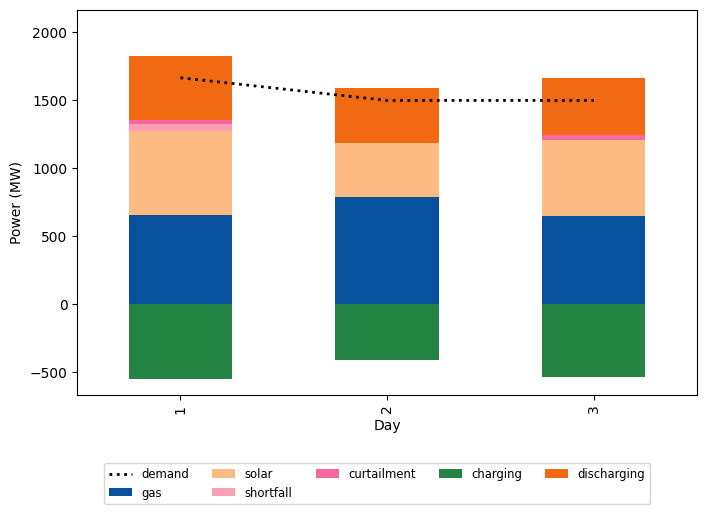

In [12]:
visualizer = Visualizer(inputs.model_id)
visualizer.plot_fuelmix_bar(dispatch=daily_generation, demand=daily_demand)

We can also plot the activity of the energy storage unit.

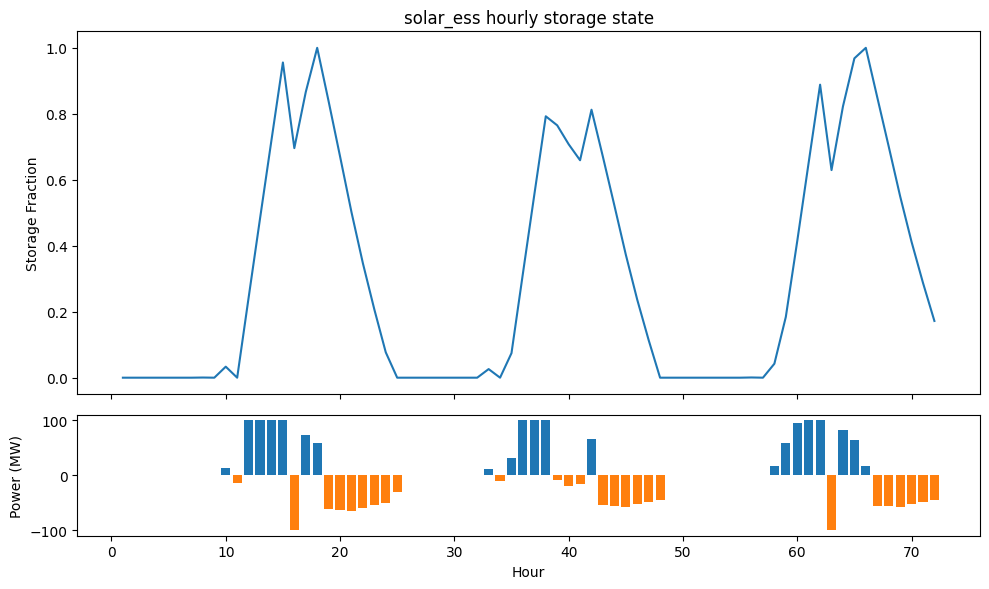

In [13]:
visualizer.plot_unit_storage_state(
    hourly_storage_charge=output_processor.get_energy_storage_hourly_charge(node_variables),
    hourly_storage_discharge=output_processor.get_energy_storage_hourly_discharge(node_variables),
    hourly_storage_state=output_processor.get_energy_storage_hourly_state(node_variables, max_storage=inputs.ess_max_capacity),
)

## Conclusion

This concludes the demonstration of the flexible PowNet modeling workflow using individual classes. The objects presented (`DataProcessor`, `SystemInput`, `ModelBuilder`, `SystemRecord`, `OutputProcessor`, `Visualizer`) offer various methods and arguments for customization. Please refer to the PowNet API documentation for more comprehensive details on their capabilities.